In [11]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

from itertools import combinations
import plotly.subplots as sp
import plotly.graph_objects as go
import plotly.express as px
import torch
import numpy as np
from univ_utils import load_model_and_sae, get_running_activation_stats, load_data
device = "cuda" if torch.cuda.is_available() else "cpu"

#### Universality across models for final checkpoints

In [2]:
# how many sequences to use? 
# Anthropic trained on 40,960,000 tokens
# And they most likely used 1024 as context length
# So 40_960_000 / 1024 = 40_000 sequences
# I have 512 context length but I can still use 40_000 sequences
# with batch size 128, this amounts to 40_000 / 128 = 312.5 batches

In [3]:
# new model-sae pairs, all 24k latents
model_sae_pairs = [
    ("8-768", "443ngubm"),
    ("8-512", "fyqbawtf"),
    ("8-256", "7g6hq05j"),
    ("8-128", "ngd29532"),
]

In [4]:
# load all stats
all_stats = {}
for (model1_name, sae1_name), (model2_name, sae2_name) in combinations(model_sae_pairs, 2):
    stats = torch.load(f"stats_data/stats_{model1_name}_{model2_name}_{sae1_name}_{sae2_name}.pt")
    all_stats[(model1_name, sae1_name), (model2_name, sae2_name)] = stats.to_cpu()

/tmp/ipykernel_480939/2007563507.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  stats = torch.load(f"stats_data/stats_{model1_name}_{model2_name}_{sae1_name}_{sae2_name

In [7]:
# load all masks
loaded_masks = {}
for model1_name, sae1_name in model_sae_pairs:
    uninterpretable_cluster_indices = torch.load(f"sae_checkpoints/{model1_name}-final/{sae1_name}/final_1024000000/uninterpretable_cluster_indices.pt")
    loaded_masks[(model1_name, sae1_name)] = uninterpretable_cluster_indices

/tmp/ipykernel_480939/1902759569.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  uninterpretable_cluster_indices = torch.load(f"sae_checkpoints/{model1_name}-final/{sae1

In [9]:
uninterpretable_cluster_indices.shape

(24576,)

In [12]:
all_scatter_data = []
all_corr_coefs = []
all_subplot_titles = []
masked_scatter_data = []
masked_corr_coefs = []
masked_subplot_titles = []
masks = []
num_layers = lambda model_name: int((model_name.split("-"))[1])

for model1_name, sae1_name in model_sae_pairs:
    for model2_name, sae2_name in model_sae_pairs:
        if model1_name == model2_name:
            all_subplot_titles.append("____")
            masked_subplot_titles.append("____")
            continue

        if ((model1_name, sae1_name), (model2_name, sae2_name)) in all_stats:
            stats = all_stats[(model1_name, sae1_name), (model2_name, sae2_name)]
            x = stats.max_x
            y = stats.corr_matrix.amax(dim=-1)
        else:
            stats = all_stats[(model2_name, sae2_name), (model1_name, sae1_name)]
            x = stats.max_y
            y = stats.corr_matrix.amax(dim=0)

        all_scatter_data.append((x, y))

        # corr coef
        corr_coef = torch.corrcoef(torch.stack((x, y), dim=0))[0, 1].item()
        all_corr_coefs.append(corr_coef)

        # masked scatter plot data
        mask = loaded_masks[(model1_name, sae1_name)]
        masks.append(np.copy(mask))
        x = x[~mask]
        y = y[~mask]
        masked_scatter_data.append((x, y))
        masked_corr_coef = torch.corrcoef(torch.stack((x, y), dim=0))[0, 1].item()
        masked_corr_coefs.append(masked_corr_coef)


        # subplot title
        nl1, nl2 = num_layers(model1_name), num_layers(model2_name)
        all_subplot_titles.append(f"Corr={corr_coef:.4f}")
        masked_subplot_titles.append(f"Corr={masked_corr_coef:.4f}")


In [23]:
import matplotlib.pyplot as plt
import numpy as np

grid_length = len(model_sae_pairs)
grid_titles = [f"n_layers={model_name.split('-')[1]}" for model_name, _ in model_sae_pairs]

def plot_grid_matplotlib(scatter_data, corr_coefs, grid_length = grid_length, grid_titles = grid_titles):

    # Create the subplot grid
    fig, axes = plt.subplots(grid_length, grid_length, figsize=(12, 12))
    plt.suptitle("Feature Importance (x-axis) vs Universality (y-axis)", y=0.92)

    i = 0
    for row in range(grid_length):
        for col in range(grid_length):
            ax = axes[row, col]
            if row == col:
                # Hide diagonal subplots
                ax.axis("off")
                continue
            
            # Plot scatter data
            x, y = scatter_data[i]
            corr_coef = corr_coefs[i]
            
            ax.scatter(x, y, s=10, alpha=0.7)
            ax.set_title(f"r={corr_coef:.4f}", fontsize=10)  # Add correlation coefficient to title
            if col == 0:
                ax.set_ylabel(grid_titles[row], fontsize=10)
            if row == grid_length - 1:
                ax.set_xlabel(grid_titles[col], fontsize=10)
            
            i += 1

    # Adjust spacing
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    # Display the plot
    plt.show()



2

In [35]:
plot_grid_matplotlib(masked_scatter_data.log(), masked_corr_coefs, grid_length, masked_subplot_titles)

AttributeError: 'list' object has no attribute 'log'

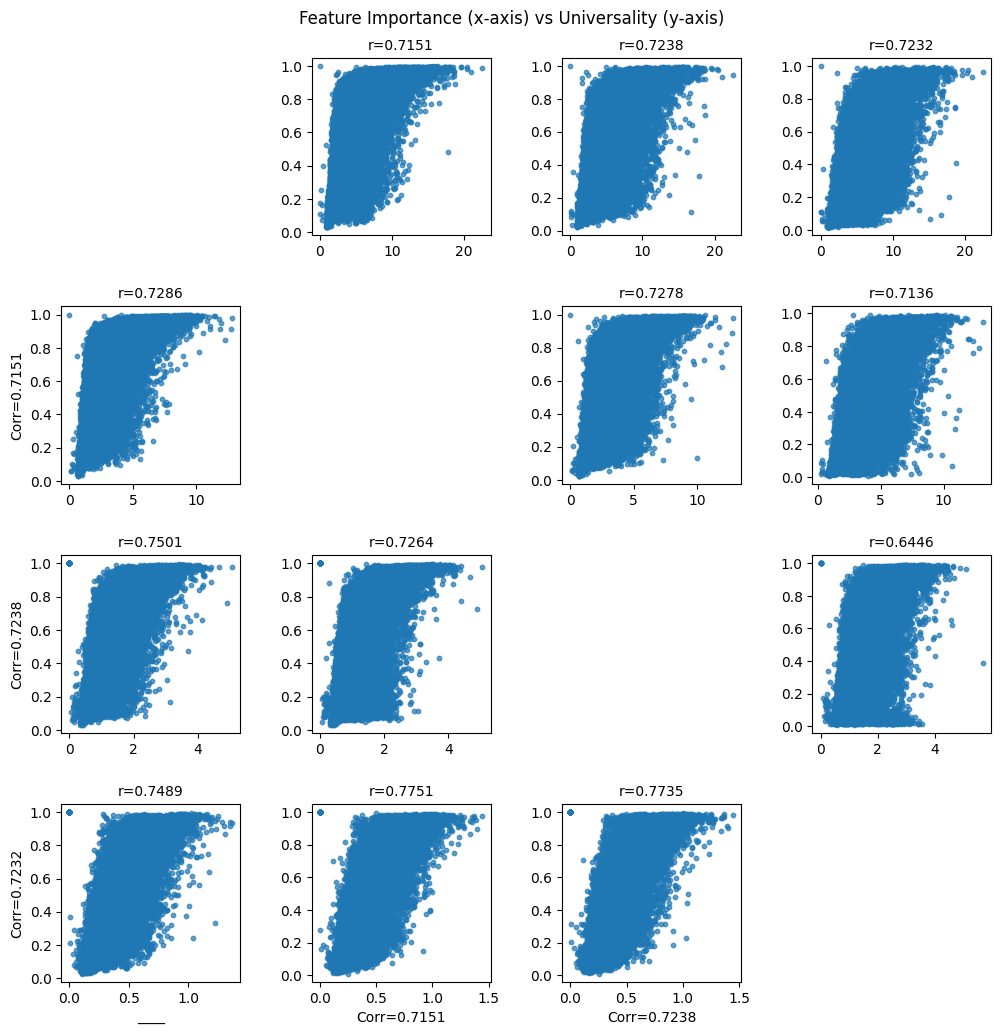

In [34]:
plot_grid_matplotlib(masked_scatter_data, masked_corr_coefs, grid_length, masked_subplot_titles)

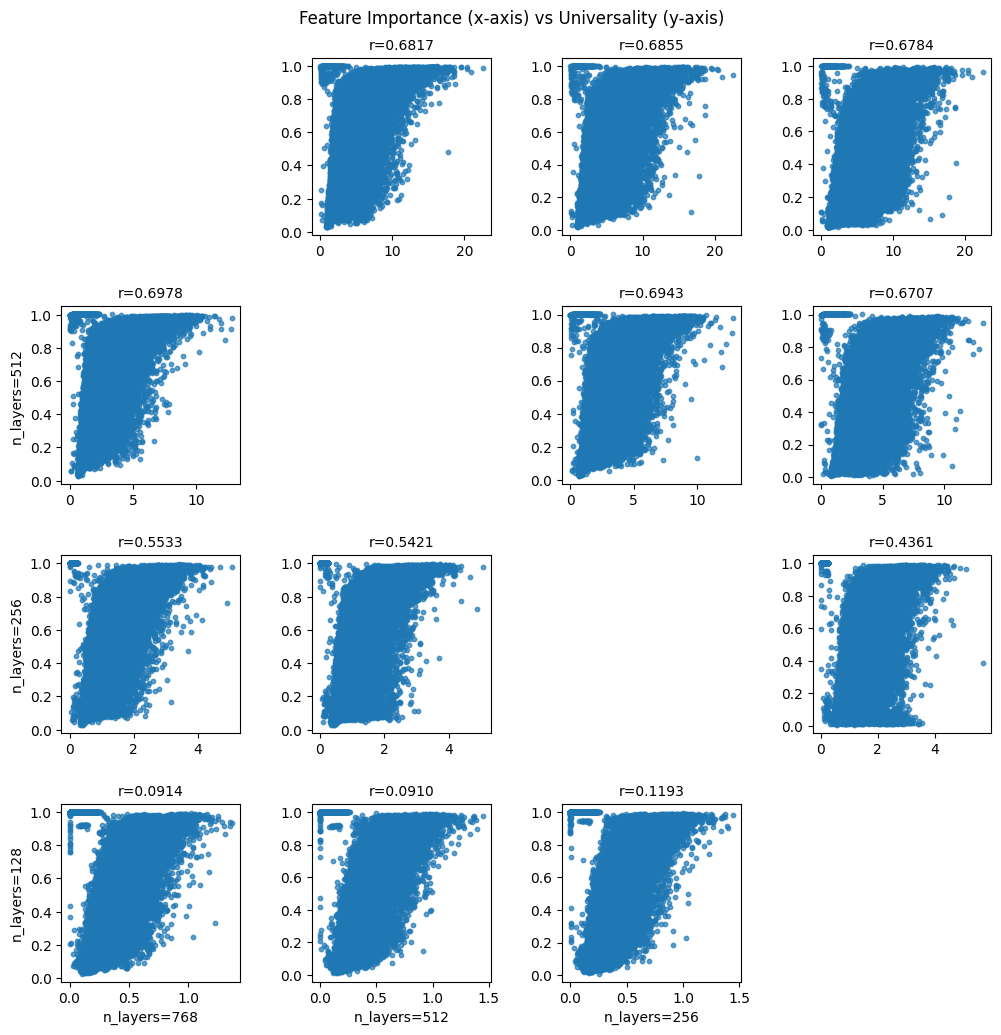

In [24]:
plot_grid_matplotlib(all_scatter_data, all_corr_coefs, grid_length, grid_titles)

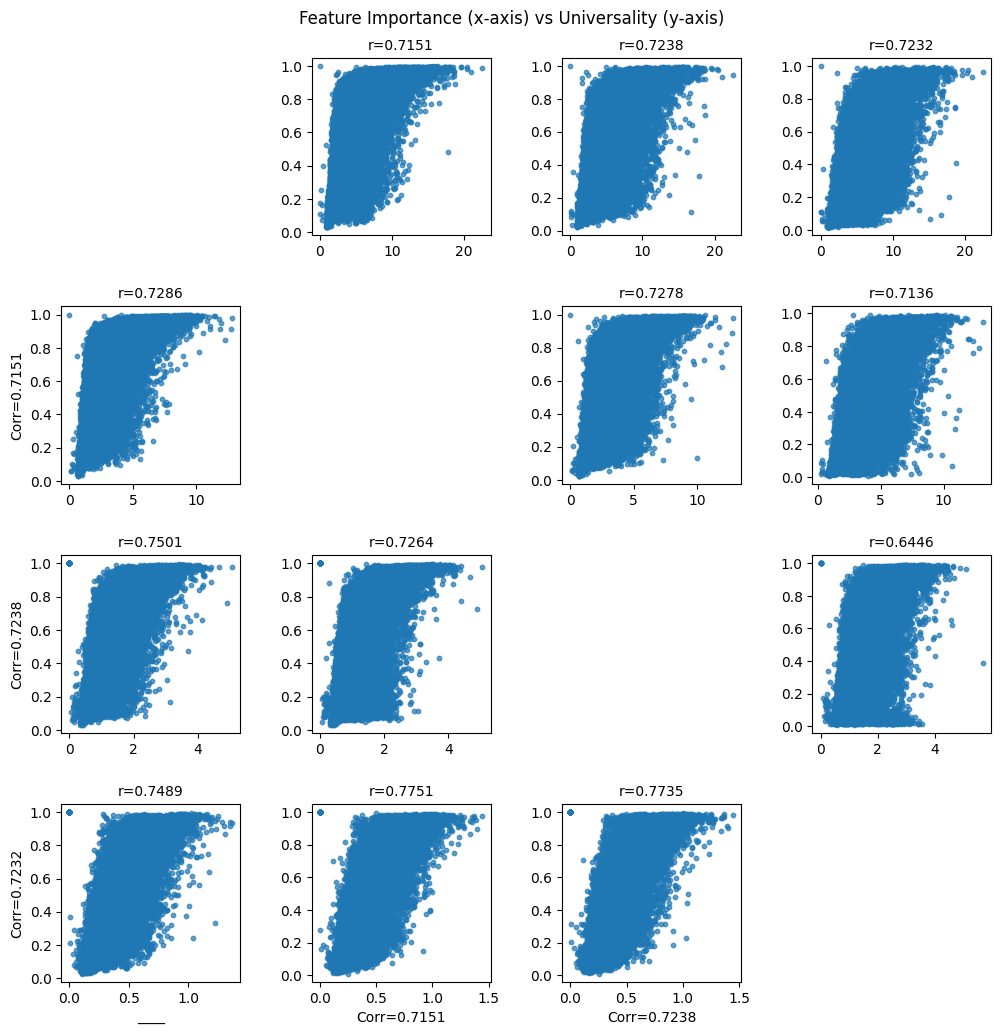

In [25]:
plot_grid_matplotlib(masked_scatter_data, masked_corr_coefs, grid_length, masked_subplot_titles)

In [31]:
def plot_grid_plotly(scatter_data, corr_coefs, subplot_titles,
                      name = "all",
                      grid_length = grid_length, grid_titles = grid_titles):
    assert name in ["all", "masked"]
    fig = sp.make_subplots(rows=grid_length, cols=grid_length, subplot_titles=subplot_titles, 
                           row_titles=grid_titles, column_titles=grid_titles,
                       x_title="Maximum Feature Activation", y_title="Maximum Activation Similarity",
                       horizontal_spacing=0.05, vertical_spacing=0.05)

    i = 0
    for row in range(1, grid_length + 1):
        for col in range(1, grid_length + 1):
            if row == col:
                continue

            x, y = scatter_data[i]
            corr_coef = corr_coefs[i]

            fig.add_trace(
                go.Scatter(x=x.numpy(), y=y.numpy(), mode='markers', name=""),
                row=row, col=col
            )
            i += 1


    for i in range(grid_length):
        fig.layout.annotations[grid_length**2 + i].update(y=1.025)

    fig.update_layout(
        title_text="Feature Importance (x-axis) vs Universality (y-axis)",
        showlegend=False,
        height=2000,
        width=2000,
    )

    os.makedirs("plots", exist_ok=True)
    fig.write_html(f"plots/imp_vs_uni_{name}.html")
    print(f"Saved {name} plot to plots/imp_vs_uni_{name}.html")

    return fig

In [32]:
fig = plot_grid_plotly(all_scatter_data, all_corr_coefs, all_subplot_titles, name = "all")

Saved all plot to plots/imp_vs_uni_all.html


In [33]:
fig = plot_grid_plotly(masked_scatter_data, masked_corr_coefs, masked_subplot_titles, name = "masked")

Saved masked plot to plots/imp_vs_uni_masked.html


### Removing unitnerpretable features from each SAE

In [10]:
# TODO: you know it's possible that this cluster of features is actually interpretable, 
# but it does something different from the rest of them.

In [14]:
model1_name, sae1_name = model_sae_pairs[2]
model1, sae1 = load_model_and_sae(model1_name, sae1_name, None, device)

/home/zara-ss/Documents/feature_universality/univ_utils.py:47: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

/home/zara-ss/Documents/feature_universality/SAELens/sae_lens/sa

In [12]:
w_dec = sae1.W_dec.clone().detach().cpu().numpy()
mask = torch.zeros(w_dec.shape[0])
embedding, fig = create_umap_visualization(w_dec, mask)

/home/zara-ss/Documents/feature_universality/env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/home/zara-ss/Documents/feature_universality/env/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning:

The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.



In [13]:
fig.show()

In [40]:
import numpy as np
from sklearn.cluster import DBSCAN

# Assume `umap_embeddings` is your UMAP output (n_points, 2) array
# Replace `umap_embeddings` with the actual array of your UMAP points

# Cluster the points
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Adjust `eps` and `min_samples` as needed
labels = dbscan.fit_predict(embedding)

# Convert cluster labels to boolean tensor
boolean_tensor = (labels == 1)  # Example: Cluster labeled as '1'

print("Cluster Labels:", labels)
print("Boolean Tensor:", boolean_tensor)

Cluster Labels: [0 0 0 ... 0 0 0]
Boolean Tensor: [False False False ... False False False]


In [ ]:
# Interestingly some times there are 3 clusters!

In [41]:
embedding, fig = create_umap_visualization(w_dec, boolean_tensor)
fig.show()

/home/zara-ss/Documents/feature_universality/env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [42]:
from sklearn.cluster import KMeans

# Assume `umap_embeddings` is your UMAP output (n_points, 2) array

# Cluster the points into 2 clusters
kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(embedding)

# Convert cluster labels to a boolean tensor
# You can select either label as 'True' depending on your use case
boolean_tensor = (labels == 1)  # Replace '1' with '0' for the other cluster

print("Cluster Labels:", labels)
print("Boolean Tensor:", boolean_tensor)

Cluster Labels: [0 0 0 ... 0 0 0]
Boolean Tensor: [False False False ... False False False]


In [43]:
embedding, fig = create_umap_visualization(w_dec, boolean_tensor)
fig.show()

/home/zara-ss/Documents/feature_universality/env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [44]:
# Can I plot mutual cosine similarity between the features in each cluster?

cos_sims_matrix = lambda tensor: np.triu(tensor @ tensor.transpose())
cos_sims = lambda tensor: cos_sims_matrix(tensor)[cos_sims_matrix(tensor) != 0].flatten()

flatten = cos_sims(w_dec[boolean_tensor])
print(np.median(flatten))
fig1 = px.histogram(flatten)
fig1.show()

In [35]:
# Can I plot mutual cosine similarity between the features in each cluster?

cos_sims_matrix = lambda tensor: np.triu(tensor @ tensor.transpose())
cos_sims = lambda tensor: cos_sims_matrix(tensor)[cos_sims_matrix(tensor) != 0].flatten()

flatten = cos_sims(w_dec[~boolean_tensor])
print(np.median(flatten))
fig1 = px.histogram(flatten)
fig1.show()

In [36]:
np.median(flatten)

0.0025844239